In [16]:
!pip install transformers accelerate bitsandbytes >> /dev/null

Trainer is a simple but feature-complete training and eval loop for PyTorch, optimized for 🤗 Transformers.

- model (PreTrainedModel or torch.nn.Module, optional) — The model to train, evaluate or use for predictions. 

- args (TrainingArguments, optional) — The arguments to tweak for training. Will default to a basic instance of TrainingArguments 

- train_dataset (torch.utils.data.Dataset or torch.utils.data.IterableDataset, optional) — The dataset to use for training. If it is a Dataset, columns not accepted by the model.forward() method are automatically removed.


- eval_dataset — The dataset to use for evaluation. If it is a Dataset, columns not accepted by the model.forward() method are automatically removed. If it is a dictionary, it will evaluate on each dataset prepending the dictionary key to the metric name.

- tokenizer (PreTrainedTokenizerBase, optional) — The tokenizer used to preprocess the data. If provided, will be used to automatically pad the inputs to the maximum length when batching inputs, and it will be saved along the model to make it easier to rerun an interrupted training or reuse the fine-tuned model.

- model_init (Callable[[], PreTrainedModel], optional) — A function that instantiates the model to be used. If provided, each call to train() will start from a new instance of the model as given by this function.

- compute_metrics (Callable[[EvalPrediction], Dict], optional) — The function that will be used to compute metrics at evaluation. Must take a EvalPrediction and return a dictionary string to metric values.

- callbacks (List of TrainerCallback, optional) — A list of callbacks to customize the training loop. Will add those to the list of default callbacks detailed in here.

- optimizers (Tuple[torch.optim.Optimizer, torch.optim.lr_scheduler.LambdaLR], optional, defaults to (None, None)) — A tuple containing the optimizer and the scheduler to use. Will default to an instance of AdamW on your model and a scheduler given by get_linear_schedule_with_warmup() controlled by args.

- preprocess_logits_for_metrics (Callable[[torch.Tensor, torch.Tensor], torch.Tensor], optional) — A function that preprocess the logits right before caching them at each evaluation step. Must take two tensors, the logits and the labels, and return the logits once processed as desired. The modifications made by this function will be reflected in the predictions received by compute_metrics.


When training large models, there are two aspects that should be considered at the same time:

- Data throughput/training time

- Model performance

Maximizing the throughput (samples/second) leads to lower training cost. This is generally achieved by utilizing the GPU as much as possible and thus **filling GPU memory** to its limit. 

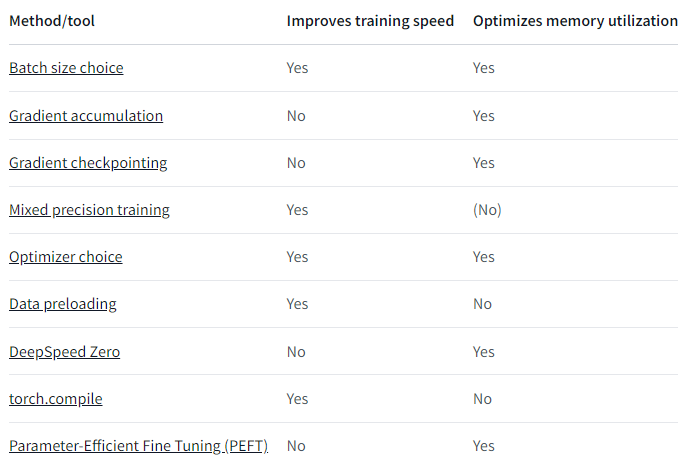

If these methods do not result in sufficient gains, you can explore the following options:

- Look into building your own custom Docker container with efficient softare prebuilds

- Consider a model that uses Mixture of Experts (MoE)

- Convert your model to BetterTransformer to leverage PyTorch native attention

- **Batch Size :** To achieve optimal performance, start by identifying the appropriate batch size. It is recommended to use batch sizes and input/output neuron counts that are of size 2^N. Often it’s a multiple of 8, but it can be higher depending on the hardware being used and the model’s dtype.

- **Gradient Accumulation:** This approach involves iteratively calculating gradients in smaller batches by performing forward and backward passes through the model and accumulating the gradients during the process. By employing gradient accumulation, it becomes possible to **increase the effective batch size** beyond the limitations imposed by the GPU’s memory capacity

In [2]:
default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "steps",
    "num_train_epochs": 1,
    "log_level": "error",
    "report_to": "none"
}

In [20]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(per_device_train_batch_size=4,
                                  gradient_accumulation_steps=4, **default_args)

# If you would like to train with batches of size 64, do not set the per_device_train_batch_size
# to 1 and gradient_accumulation_steps to 64. Instead, keep per_device_train_batch_size=4 and 
# set gradient_accumulation_steps=16. This results in the same effective batch size while 
# making better use of the available GPU resources.

using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices


In [21]:
model = AutoModelForCausalLM.from_pretrained("gpt2")

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/11c5a3d5811f50298f278a704980280950aedb10/config.json
Model config GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_vers

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/11c5a3d5811f50298f278a704980280950aedb10/model.safetensors
Generate config GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256
}

All model checkpoint weights were used when initializing GPT2LMHeadModel.

All the weights of GPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GPT2LMHeadModel for predictions without further training.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/11c5a3d5811f50298f278a704980280950aedb10/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256
}



In [8]:
training_args.per_device_train_batch_size

4

In [9]:
training_args.train_batch_size

4

In [10]:
training_args.gradient_accumulation_steps

4

In [11]:
#Gradient checkpointing offers a compromise between these two approaches and 
# saves strategically selected activations throughout the computational graph so 
# only a fraction of the activations need to be re-computed for the gradients. 
# This option slows training by 20%

training_args = TrainingArguments(per_device_train_batch_size=1,
                                 gradient_accumulation_steps=4,
                                 gradient_checkpointing=True,
                                 **default_args)

In [ ]:
# Mixed precision training is a technique that aims to optimize the computational efficiency of training models by 
# utilizing lower-precision numerical formats for certain variables. 
# Most commonly mixed precision training is achieved by using fp16 (float16) data types, however, some 
# GPU architectures (such as the Ampere architecture) offer bf16 and tf32 (CUDA internal data type) data types.

#FP16
training_args = TrainingArguments(per_device_train_batch_size=4,
                                 fp16=True, **default_args)
# BF16
training_args = TrainingArguments(per_device_train_batch_size=4,
                                 bf16=True, **default_args)


# It’s “magical” in the sense that you can use the normal fp32 training and/or 
# inference code and by enabling tf32 support you can get up to 3x throughput improvement

import torch
torch.backends.cuda.matmul.allow_tf32 = True  # CUDA will automatically move to tf32 in Ampere technology
torch.backends.cudnn.allow_tf32 = True

# tf32 can’t be accessed directly via tensor.to(dtype=torch.tf32) because it is an 
# internal CUDA data type. You need torch>=1.7 to use tf32 data types.

### Optimizers

##### Trainer integrates a variety of optimizers that can be used out of box: 

- adamw_hf

- adamw_torch

- adamw_torch_fused

- adamw_apex_fused

- adamw_anyprecision

- adafactor

- adamw_bnb_8bit. 

More optimizers can be plugged in via a third-party implementation.

For comparison, for a 3B-parameter model, like “t5-3b”:

- A standard AdamW optimizer will need 24GB of GPU memory because it uses 8 bytes for each parameter (8*3 => 24GB)

- Adafactor optimizer will need more than 12GB. It uses slightly more than 4 bytes for each parameter, so 4*3 and then some extra.

- 8bit BNB quantized optimizer will use only (2*3) 6GB if all optimizer states are quantized.

In [12]:
# Adafactor 

training_args = TrainingArguments(per_device_train_batch_size=4,
                                 optim="adafactor",
                                 **default_args)

In [14]:
# Instead of aggregating optimizer states like Adafactor, 8-bit Adam keeps the full state and quantizes it. Quantization means 
# that it stores the state with lower precision and dequantizes it only for the optimization.

training_args = TrainingArguments(per_device_train_batch_size=4, optim="adamw_bnb_8bit", **default_args)

training_args

TrainingArguments(
_n_gpu=0,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
gradient_checkpointing_kwargs=None,
greater_is_better=None,
group_by_l

In [17]:
import bitsandbytes as bnb
from torch import nn
from transformers.trainer_pt_utils import get_parameter_names

/opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


/opt/conda/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


In [25]:
training_args = TrainingArguments(per_device_train_batch_size=4,
                                  optim="adamw_bnb_8bit",
                                 **default_args)

using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices


In [23]:
decay_parameters = get_parameter_names(model, [nn.LayerNorm])
decay_parameters

['transformer.wte.weight',
 'transformer.wpe.weight',
 'transformer.h.0.attn.c_attn.weight',
 'transformer.h.0.attn.c_attn.bias',
 'transformer.h.0.attn.c_proj.weight',
 'transformer.h.0.attn.c_proj.bias',
 'transformer.h.0.mlp.c_fc.weight',
 'transformer.h.0.mlp.c_fc.bias',
 'transformer.h.0.mlp.c_proj.weight',
 'transformer.h.0.mlp.c_proj.bias',
 'transformer.h.1.attn.c_attn.weight',
 'transformer.h.1.attn.c_attn.bias',
 'transformer.h.1.attn.c_proj.weight',
 'transformer.h.1.attn.c_proj.bias',
 'transformer.h.1.mlp.c_fc.weight',
 'transformer.h.1.mlp.c_fc.bias',
 'transformer.h.1.mlp.c_proj.weight',
 'transformer.h.1.mlp.c_proj.bias',
 'transformer.h.2.attn.c_attn.weight',
 'transformer.h.2.attn.c_attn.bias',
 'transformer.h.2.attn.c_proj.weight',
 'transformer.h.2.attn.c_proj.bias',
 'transformer.h.2.mlp.c_fc.weight',
 'transformer.h.2.mlp.c_fc.bias',
 'transformer.h.2.mlp.c_proj.weight',
 'transformer.h.2.mlp.c_proj.bias',
 'transformer.h.3.attn.c_attn.weight',
 'transformer.h.3.a

In [24]:
decay_parameters = [name for name in decay_parameters if "bias" not in name]
decay_parameters  # there will be bias for every layer.

['transformer.wte.weight',
 'transformer.wpe.weight',
 'transformer.h.0.attn.c_attn.weight',
 'transformer.h.0.attn.c_proj.weight',
 'transformer.h.0.mlp.c_fc.weight',
 'transformer.h.0.mlp.c_proj.weight',
 'transformer.h.1.attn.c_attn.weight',
 'transformer.h.1.attn.c_proj.weight',
 'transformer.h.1.mlp.c_fc.weight',
 'transformer.h.1.mlp.c_proj.weight',
 'transformer.h.2.attn.c_attn.weight',
 'transformer.h.2.attn.c_proj.weight',
 'transformer.h.2.mlp.c_fc.weight',
 'transformer.h.2.mlp.c_proj.weight',
 'transformer.h.3.attn.c_attn.weight',
 'transformer.h.3.attn.c_proj.weight',
 'transformer.h.3.mlp.c_fc.weight',
 'transformer.h.3.mlp.c_proj.weight',
 'transformer.h.4.attn.c_attn.weight',
 'transformer.h.4.attn.c_proj.weight',
 'transformer.h.4.mlp.c_fc.weight',
 'transformer.h.4.mlp.c_proj.weight',
 'transformer.h.5.attn.c_attn.weight',
 'transformer.h.5.attn.c_proj.weight',
 'transformer.h.5.mlp.c_fc.weight',
 'transformer.h.5.mlp.c_proj.weight',
 'transformer.h.6.attn.c_attn.weig

In [26]:
training_args.weight_decay

0.0

In [27]:
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if n in decay_parameters],
        "weight_decay": training_args.weight_decay,
    },
    {
        "params": [p for n, p in model.named_parameters() if n not in decay_parameters],
        "weight_decay": 0.0,
    },
]

In [29]:
optimizer_kwargs = {
    "betas": (training_args.adam_beta1, training_args.adam_beta2),
    "eps": training_args.adam_epsilon,
}
optimizer_kwargs

{'betas': (0.9, 0.999), 'eps': 1e-08}

In [30]:
optimizer_kwargs["lr"] = training_args.learning_rate

adam_bnb_optim = bnb.optim.Adam8bit(
    optimizer_grouped_parameters,
    betas=(training_args.adam_beta1, training_args.adam_beta2),
    eps=training_args.adam_epsilon,
    lr=training_args.learning_rate,
)

adam_bnb_optim

Adam8bit (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 5e-05
    weight_decay: 0.0

Parameter Group 1
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 5e-05
    weight_decay: 0.0
)

In [31]:
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=ds,
                  optimizers=(adam_bnb_optim, None))

NameError: name 'ds' is not defined

### One of the important requirements: 

To reach great training speed is the ability to feed the GPU at the maximum speed it can handle. 

- DataLoader(pin_memory=True, ...) - ensures the data gets preloaded into the pinned memory on CPU and typically leads to much faster transfers from CPU to GPU memory.

- DataLoader(num_workers=4, ...) - spawn several workers to preload data faste

### Deepspeed Zero

- If the model doesn’t fit onto a single GPU or you can’t fit a small batch, you can leverage DeepSpeed ZeRO + CPU Offload, or NVMe Offload for much larger models.

In [ ]:
from accelerate import Accelerator
from torch.utils.data.dataloader import DataLoader

dataloader = DataLoader(ds, batch_size=training_args.per_device_train_batch_size)

if training_args.gradient_checkpointing:
    model.gradient_checkpointing_enable()
    
accelerator = Accelerator(fp16=training_args.fp16)

model, optimizer, dataloader = accelerator.prepare(model,
                                                   adam_bnb_optim,
                                                   dataloader)


In [ ]:
model.train()

for step, batch in enumerate(dataloader, start=1):
    loss = model(**batch).loss
    loss = loss / training_args.gradient_accumulation_steps
    accelerator.backward(loss)
    if step % training_args.gradient_accumulation_steps == 0:
        optimizer.step()
        optimizer.zero_grad()

**Mixture of Experts**

Since it has been discovered that more parameters lead to better performance, this technique allows to increase the number of parameters by an order of magnitude without increasing training costs.

In this approach every other FFN layer is replaced with a **MoE Layer which consists of many experts**, with a gated function that trains each expert in a balanced way depending on the input token’s position in a sequence.

You can find exhaustive details and comparison tables in the papers listed at the end of this section.

The main drawback of this approach is that it requires staggering amounts of GPU memory - almost an order of magnitude larger than its dense equivalent. Various distillation and approaches are proposed to how to overcome the much higher memory requirements.

There is direct trade-off though, you can use just a few experts with a 2-3x smaller base model instead of dozens or hundreds experts leading to a 5x smaller model and thus increase the training speed moderately while increasing the memory requirements moderately as well.